# MAC0417/5768 - Visão e Processamento de Imagens

**Aluno**: Lucas Martinuzzo Batista

## EP3.2 Classificação do objeto de interesse
O objetivo desta etapa é classificar as imagens segmentadas e medir a performance de classificação.

O treinamento será feito com as segmentações feitas automaticamente, enquanto o teste será validado utilizando as segmentações feitas manualmente.

### Link do Repositório:
https://github.com/LucasMartinuzzo/Visao-Computacional-2020-2

### Google Drive (Apenas Imagens)

https://drive.google.com/drive/folders/1CSLHaRzTfbsbN09WyKYIs3qf_qiBkQGT?usp=sharing

### Tabela Global Sumária da Base

| Atributo | Valor |
| :- | -: |
| Número de Classes | 10 |
| Número de Imagens Diferentes | 5400 |
| Tamanho da Base| 218 mb |
| Dimensão | 240 x 320 px |

In [237]:
import pandas as pd
import numpy as np
import os
import cv2
from math import copysign,log10
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Turn on interactive mode. Turn off with plt.ioff()
plt.ion()
%matplotlib inline

In [238]:
train_bb_path = 'BoundingBoxes/AutomaticSeg'
test_bb_path = 'BoundingBoxes/ManualSeg'

In [239]:
def makeBoudingBoxDF(path):
    bb = []
    files = os.listdir(path)
    for file in files:
        df = pd.read_csv(os.path.join(path,file))
        df['classe'] = file.split('.')[0]
        bb.append(df)
    return pd.concat(bb)

In [240]:
train_df = makeBoudingBoxDF(train_bb_path)

In [241]:
test_df = makeBoudingBoxDF(test_bb_path)

In [242]:
print(train_df.shape)
train_df.head()

(5400, 6)


,file,x,y,w,h,classe
0,../Imagens/UnetDataset/caneca\results_pos\0_pr...,43,51,149,184,caneca
1,../Imagens/UnetDataset/caneca\results_pos\100_...,24,92,134,145,caneca
2,../Imagens/UnetDataset/caneca\results_pos\101_...,46,76,148,160,caneca
3,../Imagens/UnetDataset/caneca\results_pos\102_...,19,100,164,174,caneca
4,../Imagens/UnetDataset/caneca\results_pos\103_...,32,134,128,133,caneca


In [243]:
print(test_df.shape)
test_df.head()

(895, 6)


,file,x,y,w,h,classe
0,../Imagens/UnetDataset/caneca\train/label\0.png,32,41,167,202,caneca
1,../Imagens/UnetDataset/caneca\train/label\1.png,112,111,3,1,caneca
2,../Imagens/UnetDataset/caneca\train/label\10.png,47,120,173,171,caneca
3,../Imagens/UnetDataset/caneca\train/label\11.png,158,127,2,1,caneca
4,../Imagens/UnetDataset/caneca\train/label\12.png,130,205,2,1,caneca


Hu moments são um conjunto de 7 números calculados utilizando momentos centraisque são invariantes a transformações de imagens.
A função abaixo calcula estes valores para serem utilizados como variáveis de entrada do classificador.

In [244]:
def calculateHuMoments(image):
    # Calculate Moment
    moments = cv2.moments(image)
    # Calculate Hu Moments
    hu_moments= cv2.HuMoments(moments).reshape(-1)
    for i in range(0,7):
        if hu_moments[i] != 0:
            hu_moments[i] = (-1)*copysign(1.0, hu_moments[i]) * log10(abs(hu_moments[i]))
    return hu_moments

A função abaixo lerá cada imagem e colocará o valor dos pixels no dataframe. Inverterei os valores, para que 0 seja fundo e 1 objeto. Ela também inserirá o HuMoment no dataframe.

In [245]:
def readImagesMakeAtributtes(bb_df):
    images = []
    hu_moments = []
    for image_path in bb_df['file']:
        image = cv2.imread(image_path,0)
        image = np.invert(image)
        image = image.reshape(-1)
        images.append(image)
        hu_moments.append(calculateHuMoments(image))
    images_df = pd.DataFrame(images)
    hu_moments_df = pd.DataFrame(hu_moments,columns=['HuMoment1','HuMoment2','HuMoment3','HuMoment4','HuMoment5','HuMoment6','HuMoment7'])
    df = pd.concat([bb_df.reset_index(drop=True), hu_moments_df.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), images_df.reset_index(drop=True)], axis=1)
    return df

**Aviso**: as operações abaixo irão consumir uma quantidade enorme de memória.

In [246]:
test_df = readImagesMakeAtributtes(test_df)

In [247]:
train_df = readImagesMakeAtributtes(train_df)

In [248]:
train_df.shape

(5400, 76813)

In [249]:
test_df.shape

(895, 76813)

In [250]:
test_df.head()

,file,x,y,w,h,classe,HuMoment1,HuMoment2,HuMoment3,HuMoment4,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,../Imagens/UnetDataset/caneca\train/label\0.png,32,41,167,202,caneca,-1.439446,-2.878893,-2.567206,-2.567206,...,0,0,0,0,0,0,0,0,0,0
1,../Imagens/UnetDataset/caneca\train/label\1.png,112,111,3,1,caneca,-1.416288,-2.832576,-2.674884,-2.674884,...,0,0,0,0,0,0,0,0,0,0
2,../Imagens/UnetDataset/caneca\train/label\10.png,47,120,173,171,caneca,-1.375487,-2.750975,-2.473989,-2.473989,...,0,0,0,0,0,0,0,0,0,0
3,../Imagens/UnetDataset/caneca\train/label\11.png,158,127,2,1,caneca,-1.372454,-2.744907,-2.451072,-2.451072,...,0,0,0,0,0,0,0,0,0,0
4,../Imagens/UnetDataset/caneca\train/label\12.png,130,205,2,1,caneca,-1.378083,-2.756166,-1.136310,-1.136310,...,0,0,0,0,0,0,0,0,0,0


### Principal Compoment Analysis
Utilizarei o PCA para ler os os pixels das imagens e reduzir a dimensionalidade em componentes principais.

In [261]:
pca = PCA(n_components=10)
pca_train = pca.fit_transform(train_df.drop(['file','x','y','w','h','classe','HuMoment1','HuMoment2','HuMoment3','HuMoment4','HuMoment5','HuMoment6','HuMoment7'],axis=1))

In [262]:
pca.explained_variance_ratio_

array([0.4664989 , 0.06386508, 0.0494556 , 0.03514395, 0.0268593 ,
       0.02330568, 0.02062143, 0.01404698, 0.01339074, 0.01249003])

Acima vemos que a proporção de variancia a partir da segunda componente já é muito baixa, por isso apenas a primeira será utilizada.

In [263]:
train_df['PCA'] = pd.DataFrame(pca_train[:,0], index= train_df.index)

In [264]:
pca_test = pca.transform(test_df.drop(['file','x','y','w','h','classe','HuMoment1','HuMoment2','HuMoment3','HuMoment4','HuMoment5','HuMoment6','HuMoment7'],axis=1))

In [265]:
test_df['PCA'] = pd.DataFrame(pca_test[:,0], index= test_df.index)

#### Scatter plot
Scatter plot do PCA com 2 componentes, cada cor representa uma classe.

In [266]:
# Label to color dict (manual)
label_color_dict = {'caneca':'red',
                    'caneta':'green',
                    'chave':'blue',
                    'creme_dental':'magenta',
                    'faca':'pink',
                    'fio_dental':'yellow',
                    'meia':'purple',
                    'perfume':'gray',
                    'pilha':'orange',
                    'shampoo':'brown'}

# Color vector creation
cvec = [label_color_dict[label] for label in train_df['classe']]

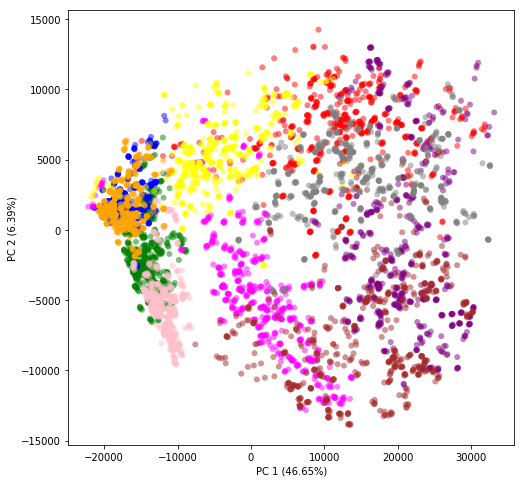

In [267]:
# Create the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(pca_train[:,0], pca_train[:,1],
            c=cvec, edgecolor='', alpha=0.5)

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# Done
plt.show()

### Exportação dos dados

In [268]:
train_df = train_df[['file','x','y','w','h','classe','HuMoment1','HuMoment2','HuMoment3','HuMoment4','HuMoment5','HuMoment6','HuMoment7','PCA']]
test_df = test_df[['file','x','y','w','h','classe','HuMoment1','HuMoment2','HuMoment3','HuMoment4','HuMoment5','HuMoment6','HuMoment7','PCA']]

In [269]:
train_df.to_csv('train.csv',index=False)
test_df.to_csv('test.csv',index=False)

### Criação do Modelo
Nesta seção o modelo será criado e as varíaveis necessárias para executa-lo serão criadas.

In [270]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [271]:
classe_dict = {'caneca':0,
                'caneta':1,
                'chave':2,
                'creme_dental':3,
                'faca':4,
                'fio_dental':5,
                'meia':6,
                'perfume':7,
                'pilha':8,
                'shampoo':9}

In [272]:
train_df['classe_n'] = train_df['classe'].replace(classe_dict)
test_df['classe_n'] = test_df['classe'].replace(classe_dict)

In [274]:
train_df.nunique()

file         5400
x             151
y             211
w             220
h             309
classe         10
HuMoment1    5399
HuMoment2    5399
HuMoment3    5399
HuMoment4    5399
HuMoment5    5399
HuMoment6    5399
HuMoment7       1
PCA          5399
classe_n       10
dtype: int64

Por algum motivo a varíavel HuMoment7 teve valor constante, então ela será retirada.

In [275]:
variaveis_selecionadas = ['HuMoment1',
                          'HuMoment2',
                          'HuMoment3',
                          'HuMoment4',
                          'HuMoment5',
                          'HuMoment6',
                          #'HuMoment7',
                          'PCA',
                         ]

#### Treinamendo utilizando variáveis que consideram as dimensões da boundingbox

In [276]:
IMAGE_SIZE = (240,320)
X_train = train_df[variaveis_selecionadas].copy()
X_train['w_percentage'] = train_df['w']/IMAGE_SIZE[0]
X_train['h_percentage'] = train_df['h']/IMAGE_SIZE[1]
X_train['perimeter'] = train_df['w']*2 + train_df['h']*2 
X_train['area'] = train_df['w']*train_df['h']
X_train['ratio'] = train_df['w']/train_df['h']
y_train = train_df.classe_n

In [277]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [278]:
X_train.shape

(5400, 12)

In [279]:
X_train.head()

,HuMoment1,HuMoment2,HuMoment3,HuMoment4,HuMoment5,HuMoment6,PCA,w_percentage,h_percentage,perimeter,area,ratio
0,-1.435883,-2.871765,-2.544294,-2.544294,-5.088587,-3.980176,21007.737243,0.620833,0.575000,666,27416,0.809783
1,-1.353685,-2.707371,-0.635754,-0.635754,-1.271508,-1.989440,12941.917155,0.558333,0.453125,558,19430,0.924138
2,-1.397788,-2.795576,-1.458349,-1.458349,-2.916698,-2.856137,15295.935783,0.616667,0.500000,616,23680,0.925000
3,-1.386008,-2.772016,-2.194248,-2.194248,-4.388495,-3.580256,20693.248422,0.683333,0.543750,676,28536,0.942529
4,-1.342616,-2.685233,-1.419343,-1.419343,-2.838687,-2.761960,8523.405807,0.533333,0.415625,522,17024,0.962406


In [280]:
X_test = test_df[variaveis_selecionadas].copy()
X_test['w_percentage'] = test_df['w']/IMAGE_SIZE[0]
X_test['h_percentage'] = test_df['h']/IMAGE_SIZE[1]
X_test['perimeter'] = test_df['w']*2 + test_df['h']*2 
X_test['area'] = test_df['w']*test_df['h']
X_test['ratio'] = test_df['w']/test_df['h']
y_test = test_df.classe_n

In [281]:
X_test_scaled = scaler.transform(X_test)

In [282]:
dtree = DecisionTreeClassifier(max_depth = 10).fit(X_train_scaled, y_train) 

linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

In [283]:
linear_pred = linear.predict(X_test_scaled)
poly_pred = poly.predict(X_test_scaled)
rbf_pred = rbf.predict(X_test_scaled)
sig_pred = sig.predict(X_test_scaled)
dtree_pred = dtree.predict(X_test_scaled) 

In [284]:
# model accuracy for X_test   
linear_accuracy = linear.score(X_test_scaled, y_test) 
poly_accuracy = poly.score(X_test_scaled, y_test) 
rbf_accuracy = rbf.score(X_test_scaled, y_test) 
sig_accuracy = sig.score(X_test_scaled, y_test) 
dtree_accuracy = dtree.score(X_test_scaled, y_test) 

In [285]:
print('Linear: ',linear_accuracy)
print('Poly: ',poly_accuracy)
print('Rbf: ',rbf_accuracy)
print('Sig: ',sig_accuracy)
print('Dtree: ',dtree_accuracy)

Linear:  0.6815642458100558
Poly:  0.6256983240223464
Rbf:  0.6256983240223464
Sig:  0.4245810055865922
Dtree:  0.7206703910614525


Com essas variáveis, o modelo de árvore de decisão obteve a melhor acurácia. Veremos mais métricas:

In [289]:
print(classification_report(y_test, dtree_pred, target_names=classe_dict.keys()))

              precision    recall  f1-score   support

      caneca       0.42      0.89      0.57        90
      caneta       0.68      0.83      0.75        90
       chave       0.64      0.84      0.73        95
creme_dental       0.74      0.78      0.76        90
        faca       0.79      0.61      0.69        90
  fio_dental       0.88      0.88      0.88        85
        meia       1.00      0.72      0.84        90
     perfume       1.00      0.61      0.76        90
       pilha       0.90      0.50      0.64        90
     shampoo       0.90      0.53      0.67        85

    accuracy                           0.72       895
   macro avg       0.79      0.72      0.73       895
weighted avg       0.79      0.72      0.73       895



#### Treinamendo sem utilizar variáveis que consideram as dimensões da boundingbox

In [305]:
IMAGE_SIZE = (240,320)
X_train = train_df[variaveis_selecionadas].copy()
y_train = train_df.classe_n

In [306]:
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [307]:
X_train.shape

(5400, 7)

In [308]:
X_train.head()

,HuMoment1,HuMoment2,HuMoment3,HuMoment4,HuMoment5,HuMoment6,PCA
0,-1.435883,-2.871765,-2.544294,-2.544294,-5.088587,-3.980176,21007.737243
1,-1.353685,-2.707371,-0.635754,-0.635754,-1.271508,-1.989440,12941.917155
2,-1.397788,-2.795576,-1.458349,-1.458349,-2.916698,-2.856137,15295.935783
3,-1.386008,-2.772016,-2.194248,-2.194248,-4.388495,-3.580256,20693.248422
4,-1.342616,-2.685233,-1.419343,-1.419343,-2.838687,-2.761960,8523.405807


In [309]:
X_test = test_df[variaveis_selecionadas].copy()
y_test = test_df.classe_n

In [310]:
X_test_scaled = scaler.transform(X_test)

In [311]:
dtree = DecisionTreeClassifier(max_depth = 10).fit(X_train_scaled, y_train) 

linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train_scaled, y_train)

In [312]:
linear_pred = linear.predict(X_test_scaled)
poly_pred = poly.predict(X_test_scaled)
rbf_pred = rbf.predict(X_test_scaled)
sig_pred = sig.predict(X_test_scaled)
dtree_pred = dtree.predict(X_test_scaled) 

In [313]:
# model accuracy for X_test   
linear_accuracy = linear.score(X_test_scaled, y_test) 
poly_accuracy = poly.score(X_test_scaled, y_test) 
rbf_accuracy = rbf.score(X_test_scaled, y_test) 
sig_accuracy = sig.score(X_test_scaled, y_test) 
dtree_accuracy = dtree.score(X_test_scaled, y_test) 

In [314]:
print('Linear: ',linear_accuracy)
print('Poly: ',poly_accuracy)
print('Rbf: ',rbf_accuracy)
print('Sig: ',sig_accuracy)
print('Dtree: ',dtree_accuracy)

Linear:  0.88268156424581
Poly:  0.8324022346368715
Rbf:  0.9497206703910615
Sig:  0.5586592178770949
Dtree:  0.9329608938547486


Com essas variáveis, o modelo SVM com kernel Rbd obteve a melhor acurácia. Veremos mais métricas:

In [317]:
print(classification_report(y_test, rbf_pred, target_names=classe_dict.keys()))

              precision    recall  f1-score   support

      caneca       0.84      0.89      0.86        90
      caneta       0.95      1.00      0.97        90
       chave       1.00      1.00      1.00        95
creme_dental       1.00      1.00      1.00        90
        faca       1.00      0.94      0.97        90
  fio_dental       0.89      1.00      0.94        85
        meia       1.00      0.67      0.80        90
     perfume       0.95      1.00      0.97        90
       pilha       1.00      1.00      1.00        90
     shampoo       0.89      1.00      0.94        85

    accuracy                           0.95       895
   macro avg       0.95      0.95      0.95       895
weighted avg       0.95      0.95      0.95       895



### Conclusão

Observa-se que utilizando apenas as variáveis construídas com o PCA e o HuMoment as métricas foram muito melhores. Minha opinião é que isso se deve por estas variáveis utilizarem de fato as características de cada segmentação, enquanto as boundingboxes são apenas retângulos e as varíaveis criadas a partir delas podem ter correlações entre as classes.

Com a excessão da meia que atingiu apenas 0.67 em recall, as precisões e recalls de cada classe foram muito boas. A acurácia geral obtida foi muito satisfatória, atingindo 0.95.